In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import missingno as msno
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import category_encoders as ce
from sklearn.preprocessing import LabelEncoder


#Makine Öğrenmesi 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
import lightgbm as lgb

In [34]:
df_ = pd.read_excel("MarketSales.xlsx")
df = df_.copy()

### Preprocess

In [28]:
def preprocess(df):
    mode_itemcode = df["ITEMCODE"].mode()[0]
    df["ITEMCODE"].fillna(mode_itemcode, inplace=True)
    df["ITEMCODE"] = df["ITEMCODE"].astype("int64")
    itemcode_to_itemname = df.dropna(subset = ["ITEMNAME"]).drop_duplicates(
    subset=["ITEMCODE"]).set_index("ITEMCODE")["ITEMNAME"].to_dict()
    df["ITEMNAME"] = df["ITEMNAME"].fillna(df["ITEMCODE"].map(itemcode_to_itemname))
    max_id = int(df["ID"].max())
    df.loc[df["ID"].isna(), "ID"] = range(max_id + 1, max_id + 1 + df["ID"].isna().sum())
    df["ID"] = df["ID"].astype("int64")
    df["CITY"].fillna(df["CITY"].mode()[0], inplace=True)
    df["REGION"].fillna(df["REGION"].mode()[0], inplace=True)
    df["CLIENTCODE"] = df.groupby(["CITY", "REGION"])["CLIENTCODE"].transform(lambda x: x.fillna(x.mode()[0]))
    
    df["CLIENTCODE"] = pd.to_numeric(df["CLIENTCODE"], errors="coerce")
    df["CLIENTCODE"].fillna(0, inplace=True) 
    df["CLIENTCODE"] = df["CLIENTCODE"].astype("int64")
    df["CLIENTNAME"] = df.groupby("CLIENTCODE")["CLIENTNAME"].transform(lambda group: group.fillna(group.mode()[0]) if not group.mode().empty else "Unknown")
    
    df["DATE_"].fillna(df["DATE_"].mode()[0], inplace=True)
    df["AMOUNT"].fillna(df["AMOUNT"].mean(), inplace=True)
    df["PRICE"].fillna(df["PRICE"].mean(), inplace=True)
    df["LINENETTOTAL"].fillna(df["LINENETTOTAL"].mean(), inplace=True)
    df["LINENET"].fillna(df["LINENET"].mean(), inplace=True)
    df["BRANCHNR"].fillna(df["BRANCHNR"].mode()[0], inplace=True)
    df["LATITUDE"].fillna(df["LATITUDE"].mean(), inplace=True)
    df["LONGITUDE"].fillna(df["LONGITUDE"].mean(), inplace=True)
    
    df["BRANCH"].fillna(df["BRANCH"].mode()[0], inplace=True)
    df["BRANCHNR"] = df["BRANCHNR"].astype("int64")
    #df["GENDER"] = df.groupby("CITY")["GENDER"].apply(lambda x: x.fillna(x.mode()[0])).reset_index(level=0, drop=True)
    df["BRANDCODE"].fillna(1234, inplace=True)

    brand_mapping = {
        1234: "BrandA",
        5678: "BrandB",}

    df["BRAND"] = df["BRANDCODE"].apply(lambda x: brand_mapping.get(x, "Unknown"))
    df["BRANDCODE"] = df["BRANDCODE"].astype("category")
    
    df["CATEGORY_NAME1"].fillna(df["CATEGORY_NAME1"].mode()[0], inplace=True)
    df["CATEGORY_NAME2"].fillna(df["CATEGORY_NAME2"].mode()[0], inplace=True)
    df["CATEGORY_NAME3"].fillna(df["CATEGORY_NAME3"].mode()[0], inplace=True)
    df["month"] = df["STARTDATE"].dt.month
    df["day"] = df["STARTDATE"].dt.day

In [35]:
preprocess(df)

### Encoding

In [36]:
label_encoder_gender = LabelEncoder()
df["GENDER"] = label_encoder_gender.fit_transform(df["GENDER"])

cols_to_encode = ["CLIENTCODE", "BRANCH", "ITEMNAME", "CATEGORY_NAME1", "CATEGORY_NAME2", 
                  "CATEGORY_NAME3", "CITY", "REGION", "BRANDCODE"]
encoder = ce.LeaveOneOutEncoder(cols=cols_to_encode, return_df=True)
df = encoder.fit_transform(df, df["AMOUNT"])


### Train-Test Split,Scale

In [37]:
X = df[["month", "day", "PRICE", "CATEGORY_NAME1", "CITY", "CLIENTCODE"]]
y = df["AMOUNT"]

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)


### Model Catboost

In [38]:
#Model
cat_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=0)
cat_model.fit(X_train, y_train)

In [39]:
cat_predictions = cat_model.predict(X_test)

In [40]:
cat_mse = mean_squared_error(y_test, cat_predictions)
print(f"CatBoost ile Ortalama Kare Hata: {cat_mse}")

CatBoost ile Ortalama Kare Hata: 0.4378510756095068


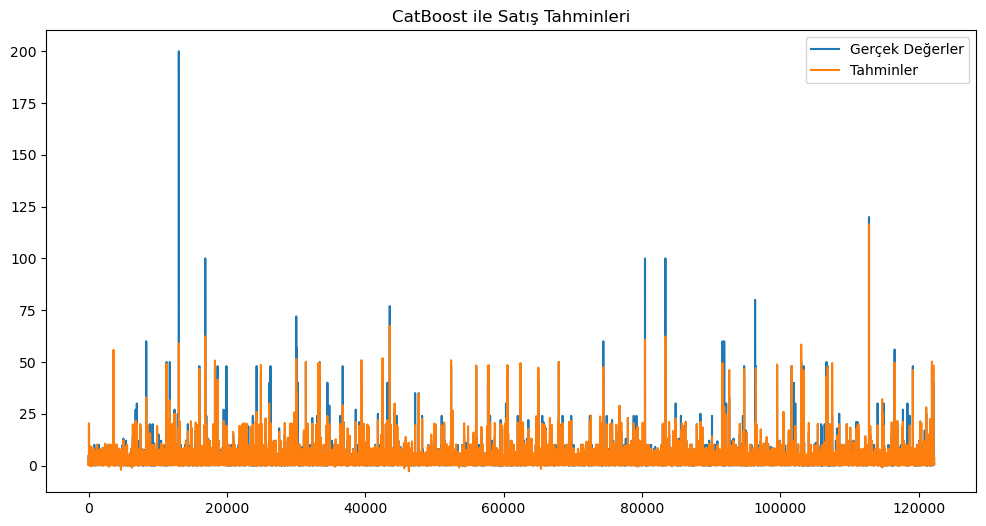

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Gerçek Değerler")
plt.plot(cat_predictions, label="Tahminler")
plt.legend()
plt.title("CatBoost ile Satış Tahminleri")
plt.show()

### Cross Validation

In [42]:
cross_val_scores = cross_val_score(cat_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-Validation Ortalama Kare Hata: ", -cross_val_scores.mean())

Cross-Validation Ortalama Kare Hata:  0.6517912625957317


### Train-Test Errors

In [43]:
#Train Errors
train_predictions = cat_model.predict(X_train)
train_mse = mean_squared_error(y_train, train_predictions)
print(f"Eğitim Hatası (MSE): {train_mse}")

Eğitim Hatası (MSE): 0.24252526596280177


In [44]:
#Test Errors
test_mse = mean_squared_error(y_test, cat_predictions)
print(f"Test Hatası (MSE): {test_mse}")

Test Hatası (MSE): 0.4378510756095068


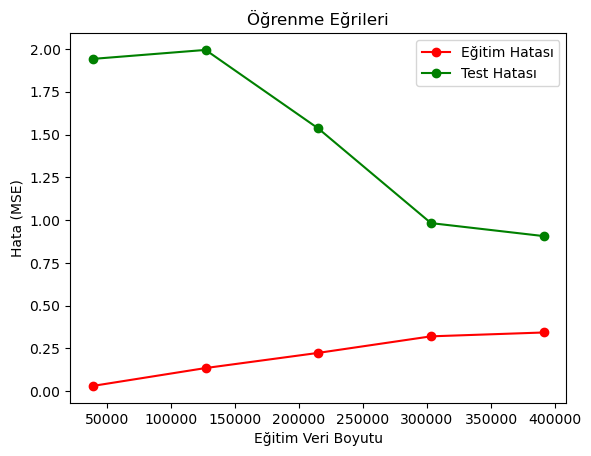

In [45]:
#Calculate the training and test errors (MSE) at different training data sizes and plot the learning curves
train_sizes, train_scores, test_scores = learning_curve(cat_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Eğitim Hatası")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test Hatası")
plt.xlabel("Eğitim Veri Boyutu")
plt.ylabel("Hata (MSE)")
plt.legend(loc="best")
plt.title("Öğrenme Eğrileri")
plt.show()

### LightGBM

In [ ]:
X = df[["month", "day", "PRICE", "CATEGORY_NAME1", "CITY", "CLIENTCODE"]]
y = df["AMOUNT"]

In [ ]:
# Scaling
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

In [ ]:
#Model
lgb_model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05)
lgb_model.fit(X_train, y_train)

In [ ]:
#Preds
lgb_predictions = lgb_model.predict(X_test)

In [ ]:
#Model Performance
lgb_mse = mean_squared_error(y_test, lgb_predictions)
print(f"LightGBM ile Ortalama Kare Hata: {lgb_mse}")

In [ ]:
#Visualizing actual and predicted sales
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Gerçek Değerler")
plt.plot(lgb_predictions, label="Tahminler")
plt.legend()
plt.title("LightGBM ile Satış Tahminleri")
plt.show()


In [ ]:
#Train Errors
train_predictions = lgb_model.predict(X_train)
train_mse = mean_squared_error(y_train, train_predictions)
print(f"Eğitim Hatası (MSE): {train_mse}")



In [ ]:
#Test Errors
test_predictions = lgb_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)
print(f"Test Hatası (MSE): {test_mse}")

### PKL

In [ ]:
#joblib.dump(cat_model, "catboost_model.pkl")
#cat_model = joblib.load("catboost_model.pkl")